In [2]:
!pip install pytorch_lightning
import torch
import torchvision
import torchmetrics
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import pytorch_lightning as pl

     |████████████████████████████████| 582 kB 4.2 MB/s 
     |████████████████████████████████| 408 kB 40.4 MB/s 
     |████████████████████████████████| 596 kB 36.7 MB/s 
     |████████████████████████████████| 136 kB 37.9 MB/s 
     |████████████████████████████████| 1.1 MB 37.4 MB/s 
     |████████████████████████████████| 271 kB 37.0 MB/s 
     |████████████████████████████████| 94 kB 2.5 MB/s 
     |████████████████████████████████| 144 kB 38.2 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
class LightningMNISTClassifier(pl.LightningModule):

    

    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1,6,5, padding = 2)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,9)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3*3*16,64)
        self.fc2 = nn.Linear(64,10)

        self.valid_acc = torchmetrics.Accuracy()
        self.test_acc = torchmetrics.Accuracy()

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        #x = torch.flatten(x, 1)
        x = self.flatten(x) 
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)

        return x

    def cross_entropy_loss(self, logits, labels):
        return F.cross_entropy(logits, labels, )

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('val_loss', loss)
        self.valid_acc(logits, y)
        self.log('valid_acc', self.valid_acc)

    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('test_loss', loss)
        self.test_acc(logits, y)
        self.log('test_acc', self.test_acc)

    def configure_optimizers(self):
        #optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-6)
        return optimizer

In [4]:
class LightningMNISTClassifier_2(pl.LightningModule):

    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1,6,5, padding = 2)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,9)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3*3*16,64)
        self.fc2 = nn.Linear(64,10)

        self.valid_acc = torchmetrics.Accuracy()
        self.test_acc = torchmetrics.Accuracy()

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        #x = torch.flatten(x, 1)
        x = self.flatten(x) 
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)

        return x

    def cross_entropy_loss(self, logits, labels):
        return F.cross_entropy(logits, labels, )

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('val_loss', loss)
        self.valid_acc(logits, y)
        self.log('valid_acc', self.valid_acc)

    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('test_loss', loss)
        self.test_acc(logits, y)
        self.log('test_acc', self.test_acc)

    def configure_optimizers(self):
        #optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [5]:
class MNISTDataModule(pl.LightningDataModule):

    def setup(self, stage):
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize(mean=[0.5],
                                 std=[0.5])])
      
        # prepare transforms standard to MNIST
        self.trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
        self.testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.testset, batch_size=10000,
                                         shuffle=False, num_workers=2)


In [6]:
AVAIL_GPUS = min(1, torch.cuda.device_count())

data_module = MNISTDataModule()

model_1 = LightningMNISTClassifier()
print(model_1.state_dict)
model_2 = LightningMNISTClassifier_2()
print(model_2.state_dict)

trainer_1 = pl.Trainer(gpus = AVAIL_GPUS, max_epochs = 1)
trainer_2 = pl.Trainer(gpus = AVAIL_GPUS, max_epochs = 15)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


<bound method Module.state_dict of LightningMNISTClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(9, 9), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=144, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (valid_acc): Accuracy()
  (test_acc): Accuracy()
)>
<bound method Module.state_dict of LightningMNISTClassifier_2(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(9, 9), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=144, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (valid_acc): Accuracy()
  (test_acc): Accuracy

In [7]:
trainer_1.fit(model_1, data_module)
trainer_2.fit(model_2, data_module)

Missing logger folder: /content/lightning_logs


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | conv1     | Conv2d    | 156   
1 | pool      | MaxPool2d | 0     
2 | conv2     | Conv2d    | 7.8 K 
3 | flatten   | Flatten   | 0     
4 | fc1       | Linear    | 9.3 K 
5 | fc2       | Linear    | 650   
6 | valid_acc | Accuracy  | 0     
7 | test_acc  | Accuracy  | 0     
----------------------------------------
17.9 K    Trainable params
0         Non-trainable params
17.9 K    Total params
0.072     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | conv1     | Conv2d    | 156   
1 | pool      | MaxPool2d | 0     
2 | conv2     | Conv2d    | 7.8 K 
3 | flatten   | Flatten   | 0     
4 | fc1       | Linear    | 9.3 K 
5 | fc2       | Linear    | 650   
6 | valid_acc | Accuracy  | 0     
7 | test_acc  | Accuracy  | 0     
----------------------------------------
17.9 K    Trainable params
0         Non-trainable params
17.9 K    Total params
0.072     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [8]:
#torch.save(model_1.state_dict(), 'cnn_mnist_1epoch.pth')

#torch.save(model, './models/mnist.pt')
#torch.load('./models/mnist.pt')

In [9]:
#state_dict = torch.load('cnn_mnist_1epoch.pth')
#model.load_state_dict(state_dict)
#trainer = pl.Trainer(limit_train_batches=0, limit_val_batches=0)
#trainer.fit(model, data_module)

#### First model - poorly trained 
- Epoch: 1
- Learning rate: 1e-6

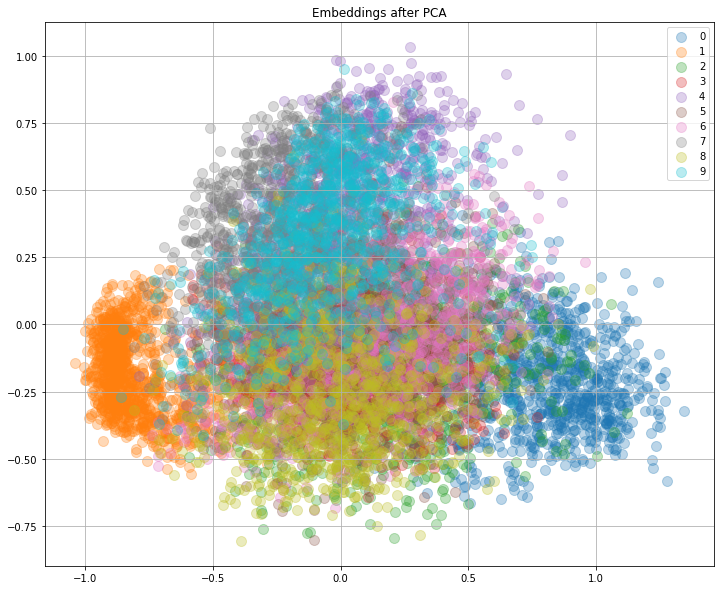

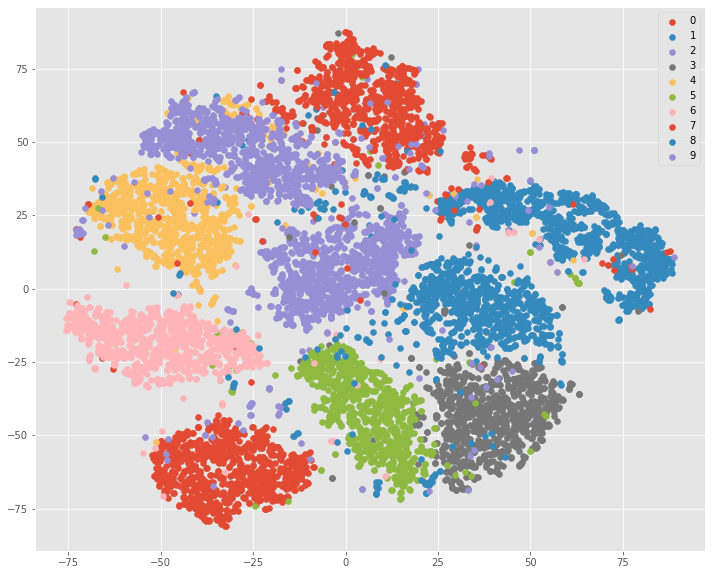

In [10]:
from torch.nn.modules import flatten
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns

activation = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

h1 = model_1.flatten.register_forward_hook(getActivation('flatten'))

dataiter = iter(data_module.val_dataloader())
images, labels = dataiter.next()

outputs_1 = model_1(images)

data_flatten = np.array(activation['flatten'])

label_flatten_unique = np.unique(np.array(labels))
label_flatten = np.array(labels)

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_flatten)

plt.figure(figsize=(12,10))
for g in label_flatten_unique:
  i = np.where(label_flatten==g)

  plt.scatter(data_pca[i,0], data_pca[i,1], s=100, alpha=0.3, label=g)
plt.title('Embeddings after PCA')
plt.grid()
plt.legend()

X = activation['flatten'].numpy()
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(X)
X_embedded.shape

plt.style.use("ggplot")
plt.figure(figsize=(12,10))

for g in label_flatten_unique:
  i = np.where(label_flatten==g)
  plt.scatter(X_embedded[i,0], X_embedded[i,1], label=g)
plt.legend() 
plt.show()

#### Trainable model 
- Epoch: 15
- Learning rate: 1e-3

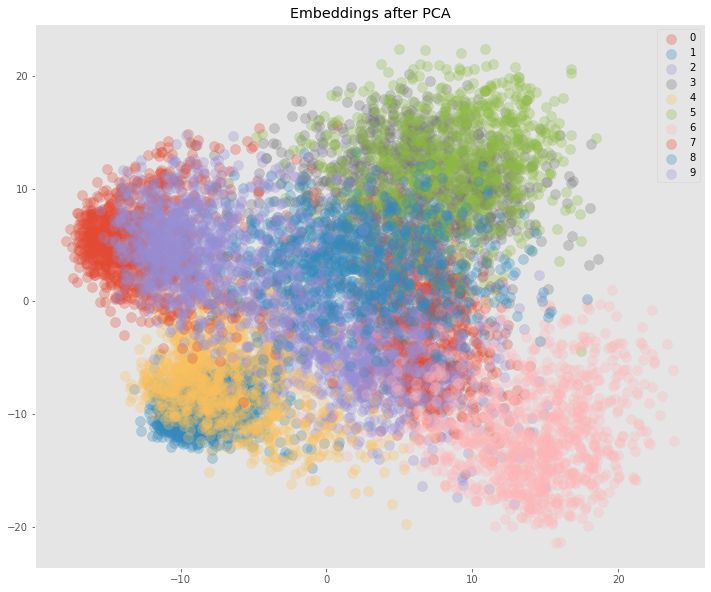

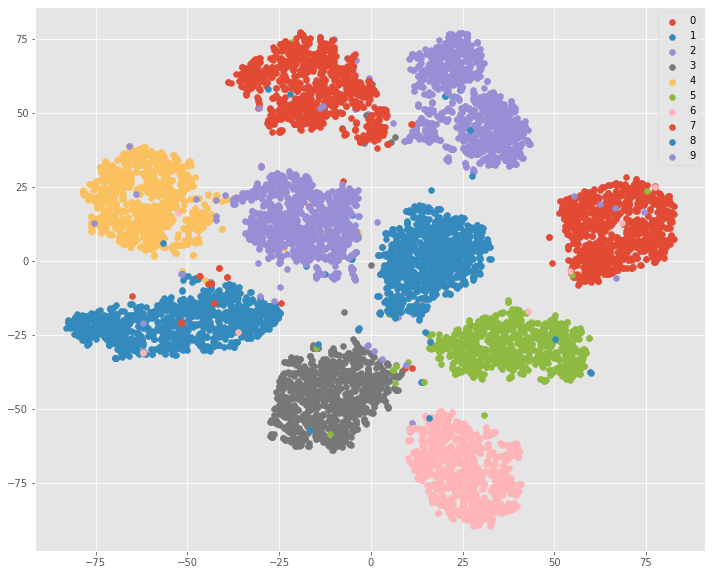

In [11]:
h2 = model_2.flatten.register_forward_hook(getActivation('flatten'))

outputs_2 = model_2(images)

data_flatten = np.array(activation['flatten'])

label_flatten_unique = np.unique(np.array(labels))
label_flatten = np.array(labels)

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_flatten)

plt.figure(figsize=(12,10))
for g in label_flatten_unique:
  i = np.where(label_flatten==g)

  plt.scatter(data_pca[i,0], data_pca[i,1], s=100, alpha=0.3, label=g)
plt.title('Embeddings after PCA')
plt.grid()
plt.legend()

X = activation['flatten'].numpy()
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(X)
X_embedded.shape

plt.style.use("ggplot")
plt.figure(figsize=(12,10))

for g in label_flatten_unique:
  i = np.where(label_flatten==g)
  plt.scatter(X_embedded[i,0], X_embedded[i,1], label=g)
plt.legend() 
plt.show()